In [23]:
%matplotlib inline
#%matplotlib qt
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [24]:
# Etiquetas de las clases
labels = ['Quieto', 'Movimiento_1', 'Movimiento_2', 'Movimiento_3', 'Movimiento_4']
warnings.filterwarnings('ignore')

### TRAIN
# reading raw data file
data_train = pd.read_csv('Archivos_CSV_con_etiquetas/Medicion_manual_train_accelGyro_etiquetado.csv')
data_train = data_train.drop(['gx','gy','gz'], axis=1)
# removing null values
data_train = data_train.dropna()
data_train.shape
# drop the rows where timestamp is 0
df = data_train[pd.to_datetime(data_train['dateTime_UTC']) != 0]
# now arrange data in ascending order of the user and timestamp
df = df.sort_values(by = ['dateTime_UTC'], ignore_index=True)


### TEST
# reading raw data file
data_test = pd.read_csv('Archivos_CSV_con_etiquetas/Medicion_manual_test_accelGyro_etiquetado.csv')
data_test = data_test.drop(['gx','gy','gz'], axis=1)
# removing null values
data_test = data_test.dropna()
data_test.shape
# drop the rows where timestamp is 0
df_test = data_test[pd.to_datetime(data_test['dateTime_UTC']) != 0]
# now arrange data in ascending order of the user and timestamp
df_test = df_test.sort_values(by = ['dateTime_UTC'], ignore_index=True)

In [27]:
accuracyX_lr = []
accuracyX_rf = []
precisionX_rf = []
precisionX_lr = []
recallX_lr = []
recallX_rf = []
fscoreX_lr = []
fscoreX_rf = []
precisionX_rf_W = []
precisionX_lr_W = []
recallX_lr_W = []
recallX_rf_W = []
fscoreX_lr_W = []
fscoreX_rf_W = []
windows = []

for i in range(10):
    #print(i)
    step_size=1+56*i
    
    window_size=2*step_size
    df_train = data_train
    df_test=data_test
    windows.append(window_size)


    ### X TRAIN
    x_list_train = []
    y_list_train = []
    z_list_train = []
    train_labels = []

    # creating overlaping windows of size window-size
    for i in range(0, df_train.shape[0] - window_size, step_size):
        xs = df_train['ax'].values[i: i + window_size]
        ys = df_train['ay'].values[i: i + window_size]
        zs = df_train['az'].values[i: i + window_size]
        label = stats.mode(df_train['Actividades'][i: i + window_size])[0][0]

        x_list_train.append(xs)
        y_list_train.append(ys)
        z_list_train.append(zs)
        train_labels.append(label)

    # Statistical Features on raw x, y and z in time domain
    X_train = pd.DataFrame()

    # mean
    X_train['x_mean'] = pd.Series(x_list_train).apply(lambda x: x.mean())
    X_train['y_mean'] = pd.Series(y_list_train).apply(lambda x: x.mean())
    X_train['z_mean'] = pd.Series(z_list_train).apply(lambda x: x.mean())

    # std dev
    X_train['x_std'] = pd.Series(x_list_train).apply(lambda x: x.std())
    X_train['y_std'] = pd.Series(y_list_train).apply(lambda x: x.std())
    X_train['z_std'] = pd.Series(z_list_train).apply(lambda x: x.std())

    # avg absolute diff
    X_train['x_aad'] = pd.Series(x_list_train).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X_train['y_aad'] = pd.Series(y_list_train).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X_train['z_aad'] = pd.Series(z_list_train).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

    # min
    X_train['x_min'] = pd.Series(x_list_train).apply(lambda x: x.min())
    X_train['y_min'] = pd.Series(y_list_train).apply(lambda x: x.min())
    X_train['z_min'] = pd.Series(z_list_train).apply(lambda x: x.min())

    # max
    X_train['x_max'] = pd.Series(x_list_train).apply(lambda x: x.max())
    X_train['y_max'] = pd.Series(y_list_train).apply(lambda x: x.max())
    X_train['z_max'] = pd.Series(z_list_train).apply(lambda x: x.max())

    # # max-min diff
    # X_train['x_maxmin_diff'] = X_train['x_max'] - X_train['x_min']
    # X_train['y_maxmin_diff'] = X_train['y_max'] - X_train['y_min']
    # X_train['z_maxmin_diff'] = X_train['z_max'] - X_train['z_min']

    # median
    X_train['x_median'] = pd.Series(x_list_train).apply(lambda x: np.median(x))
    X_train['y_median'] = pd.Series(y_list_train).apply(lambda x: np.median(x))
    X_train['z_median'] = pd.Series(z_list_train).apply(lambda x: np.median(x))

    # median abs dev 
    X_train['x_mad'] = pd.Series(x_list_train).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X_train['y_mad'] = pd.Series(y_list_train).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X_train['z_mad'] = pd.Series(z_list_train).apply(lambda x: np.median(np.absolute(x - np.median(x))))

    # interquartile range
    X_train['x_IQR'] = pd.Series(x_list_train).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X_train['y_IQR'] = pd.Series(y_list_train).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X_train['z_IQR'] = pd.Series(z_list_train).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    # negtive count
    X_train['x_neg_count'] = pd.Series(x_list_train).apply(lambda x: np.sum(x < 0))
    X_train['y_neg_count'] = pd.Series(y_list_train).apply(lambda x: np.sum(x < 0))
    X_train['z_neg_count'] = pd.Series(z_list_train).apply(lambda x: np.sum(x < 0))

    # positive count
    X_train['x_pos_count'] = pd.Series(x_list_train).apply(lambda x: np.sum(x > 0))
    X_train['y_pos_count'] = pd.Series(y_list_train).apply(lambda x: np.sum(x > 0))
    X_train['z_pos_count'] = pd.Series(z_list_train).apply(lambda x: np.sum(x > 0))

    # values above mean
    X_train['x_above_mean'] = pd.Series(x_list_train).apply(lambda x: np.sum(x > x.mean()))
    X_train['y_above_mean'] = pd.Series(y_list_train).apply(lambda x: np.sum(x > x.mean()))
    X_train['z_above_mean'] = pd.Series(z_list_train).apply(lambda x: np.sum(x > x.mean()))

    # number of peaks
    X_train['x_peak_count'] = pd.Series(x_list_train).apply(lambda x: len(find_peaks(x)[0]))
    X_train['y_peak_count'] = pd.Series(y_list_train).apply(lambda x: len(find_peaks(x)[0]))
    X_train['z_peak_count'] = pd.Series(z_list_train).apply(lambda x: len(find_peaks(x)[0]))

    # # skewness
    # X_train['x_skewness'] = pd.Series(x_list_train).apply(lambda x: stats.skew(x))
    # X_train['y_skewness'] = pd.Series(y_list_train).apply(lambda x: stats.skew(x))
    # X_train['z_skewness'] = pd.Series(z_list_train).apply(lambda x: stats.skew(x))

    # # kurtosis
    # X_train['x_kurtosis'] = pd.Series(x_list_train).apply(lambda x: stats.kurtosis(x))
    # X_train['y_kurtosis'] = pd.Series(y_list_train).apply(lambda x: stats.kurtosis(x))
    # X_train['z_kurtosis'] = pd.Series(z_list_train).apply(lambda x: stats.kurtosis(x))

    # energy
    X_train['x_energy'] = pd.Series(x_list_train).apply(lambda x: np.sum(x**2)/window_size)
    X_train['y_energy'] = pd.Series(y_list_train).apply(lambda x: np.sum(x**2)/window_size)
    X_train['z_energy'] = pd.Series(z_list_train).apply(lambda x: np.sum(x**2)/window_size)

    # avg resultant
    X_train['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list_train)**2 + pd.Series(y_list_train)**2 + pd.Series(z_list_train)**2)**0.5)]

    # signal magnitude area
    X_train['sma'] =    pd.Series(x_list_train).apply(lambda x: np.sum(abs(x)/window_size)) + pd.Series(y_list_train).apply(lambda x: np.sum(abs(x)/window_size)) \
                    + pd.Series(z_list_train).apply(lambda x: np.sum(abs(x)/window_size))
    
    # x_list_fft_train = pd.Series(x_list_train).apply(lambda x: np.abs(np.fft.fft(x))[1:step_size])
    # y_list_fft_train = pd.Series(y_list_train).apply(lambda x: np.abs(np.fft.fft(x))[1:step_size])
    # z_list_fft_train = pd.Series(z_list_train).apply(lambda x: np.abs(np.fft.fft(x))[1:step_size])

    # # Statistical Features on raw x, y and z in frequency domain
    # # FFT mean
    # X_train['x_mean_fft'] = pd.Series(x_list_fft_train).apply(lambda x: x.mean())
    # X_train['y_mean_fft'] = pd.Series(y_list_fft_train).apply(lambda x: x.mean())
    # X_train['z_mean_fft'] = pd.Series(z_list_fft_train).apply(lambda x: x.mean())

    # # FFT std dev
    # X_train['x_std_fft'] = pd.Series(x_list_fft_train).apply(lambda x: x.std())
    # X_train['y_std_fft'] = pd.Series(y_list_fft_train).apply(lambda x: x.std())
    # X_train['z_std_fft'] = pd.Series(z_list_fft_train).apply(lambda x: x.std())

    # # FFT avg absolute diff
    # X_train['x_aad_fft'] = pd.Series(x_list_fft_train).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    # X_train['y_aad_fft'] = pd.Series(y_list_fft_train).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    # X_train['z_aad_fft'] = pd.Series(z_list_fft_train).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

    # # FFT min
    # X_train['x_min_fft'] = pd.Series(x_list_fft_train).apply(lambda x: x.min())
    # X_train['y_min_fft'] = pd.Series(y_list_fft_train).apply(lambda x: x.min())
    # X_train['z_min_fft'] = pd.Series(z_list_fft_train).apply(lambda x: x.min())

    # # FFT max
    # X_train['x_max_fft'] = pd.Series(x_list_fft_train).apply(lambda x: x.max())
    # X_train['y_max_fft'] = pd.Series(y_list_fft_train).apply(lambda x: x.max())
    # X_train['z_max_fft'] = pd.Series(z_list_fft_train).apply(lambda x: x.max())

    # # FFT max-min diff
    # X_train['x_maxmin_diff_fft'] = X_train['x_max_fft'] - X_train['x_min_fft']
    # X_train['y_maxmin_diff_fft'] = X_train['y_max_fft'] - X_train['y_min_fft']
    # X_train['z_maxmin_diff_fft'] = X_train['z_max_fft'] - X_train['z_min_fft']

    # # FFT median
    # X_train['x_median_fft'] = pd.Series(x_list_fft_train).apply(lambda x: np.median(x))
    # X_train['y_median_fft'] = pd.Series(y_list_fft_train).apply(lambda x: np.median(x))
    # X_train['z_median_fft'] = pd.Series(z_list_fft_train).apply(lambda x: np.median(x))

    # # FFT median abs dev 
    # X_train['x_mad_fft'] = pd.Series(x_list_fft_train).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    # X_train['y_mad_fft'] = pd.Series(y_list_fft_train).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    # X_train['z_mad_fft'] = pd.Series(z_list_fft_train).apply(lambda x: np.median(np.absolute(x - np.median(x))))

    # # FFT Interquartile range
    # X_train['x_IQR_fft'] = pd.Series(x_list_fft_train).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    # X_train['y_IQR_fft'] = pd.Series(y_list_fft_train).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    # X_train['z_IQR_fft'] = pd.Series(z_list_fft_train).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    # # FFT values above mean
    # X_train['x_above_mean_fft'] = pd.Series(x_list_fft_train).apply(lambda x: np.sum(x > x.mean()))
    # X_train['y_above_mean_fft'] = pd.Series(y_list_fft_train).apply(lambda x: np.sum(x > x.mean()))
    # X_train['z_above_mean_fft'] = pd.Series(z_list_fft_train).apply(lambda x: np.sum(x > x.mean()))

    # # FFT number of peaks
    # X_train['x_peak_count_fft'] = pd.Series(x_list_fft_train).apply(lambda x: len(find_peaks(x)[0]))
    # X_train['y_peak_count_fft'] = pd.Series(y_list_fft_train).apply(lambda x: len(find_peaks(x)[0]))
    # X_train['z_peak_count_fft'] = pd.Series(z_list_fft_train).apply(lambda x: len(find_peaks(x)[0]))

    # # FFT skewness
    # X_train['x_skewness_fft'] = pd.Series(x_list_fft_train).apply(lambda x: stats.skew(x))
    # X_train['y_skewness_fft'] = pd.Series(y_list_fft_train).apply(lambda x: stats.skew(x))
    # X_train['z_skewness_fft'] = pd.Series(z_list_fft_train).apply(lambda x: stats.skew(x))

    # # FFT kurtosis
    # X_train['x_kurtosis_fft'] = pd.Series(x_list_fft_train).apply(lambda x: stats.kurtosis(x))
    # X_train['y_kurtosis_fft'] = pd.Series(y_list_fft_train).apply(lambda x: stats.kurtosis(x))
    # X_train['z_kurtosis_fft'] = pd.Series(z_list_fft_train).apply(lambda x: stats.kurtosis(x))

    # # FFT energy
    # X_train['x_energy_fft'] = pd.Series(x_list_fft_train).apply(lambda x: np.sum(x**2)/50)
    # X_train['y_energy_fft'] = pd.Series(y_list_fft_train).apply(lambda x: np.sum(x**2)/50)
    # X_train['z_energy_fft'] = pd.Series(z_list_fft_train).apply(lambda x: np.sum(x**2/50))

    # # FFT avg resultant
    # X_train['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft_train)**2 + pd.Series(y_list_fft_train)**2 + pd.Series(z_list_fft_train)**2)**0.5)]

    # # FFT Signal magnitude area
    # X_train['sma_fft'] = pd.Series(x_list_fft_train).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_list_fft_train).apply(lambda x: np.sum(abs(x)/50)) \
    #                     + pd.Series(z_list_fft_train).apply(lambda x: np.sum(abs(x)/50))

    # # Max Indices and Min indices 

    # # index of max value in time domain
    # X_train['x_argmax'] = pd.Series(x_list_train).apply(lambda x: np.argmax(x))
    # X_train['y_argmax'] = pd.Series(y_list_train).apply(lambda x: np.argmax(x))
    # X_train['z_argmax'] = pd.Series(z_list_train).apply(lambda x: np.argmax(x))

    # # index of min value in time domain
    # X_train['x_argmin'] = pd.Series(x_list_train).apply(lambda x: np.argmin(x))
    # X_train['y_argmin'] = pd.Series(y_list_train).apply(lambda x: np.argmin(x))
    # X_train['z_argmin'] = pd.Series(z_list_train).apply(lambda x: np.argmin(x))

    # # absolute difference between above indices
    # X_train['x_arg_diff'] = abs(X_train['x_argmax'] - X_train['x_argmin'])
    # X_train['y_arg_diff'] = abs(X_train['y_argmax'] - X_train['y_argmin'])
    # X_train['z_arg_diff'] = abs(X_train['z_argmax'] - X_train['z_argmin'])

    # # index of max value in frequency domain
    # X_train['x_argmax_fft'] = pd.Series(x_list_fft_train).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
    # X_train['y_argmax_fft'] = pd.Series(y_list_fft_train).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
    # X_train['z_argmax_fft'] = pd.Series(z_list_fft_train).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))

    # # index of min value in frequency domain
    # X_train['x_argmin_fft'] = pd.Series(x_list_fft_train).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
    # X_train['y_argmin_fft'] = pd.Series(y_list_fft_train).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
    # X_train['z_argmin_fft'] = pd.Series(z_list_fft_train).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))

    # # absolute difference between above indices
    # X_train['x_arg_diff_fft'] = abs(X_train['x_argmax_fft'] - X_train['x_argmin_fft'])
    # X_train['y_arg_diff_fft'] = abs(X_train['y_argmax_fft'] - X_train['y_argmin_fft'])
    # X_train['z_arg_diff_fft'] = abs(X_train['z_argmax_fft'] - X_train['z_argmin_fft'])


    ### X TEST
    x_list_test = []
    y_list_test = []
    z_list_test = []
    test_labels = []

    # creating overlaping windows of size window-size
    for i in range(0, df_test.shape[0] - window_size, step_size):
        xs = df_test['ax'].values[i: i + window_size]
        ys = df_test['ay'].values[i: i + window_size]
        zs = df_test['az'].values[i: i + window_size]
        label = stats.mode(df_test['Actividades'][i: i + window_size])[0][0]

        x_list_test.append(xs)
        y_list_test.append(ys)
        z_list_test.append(zs)
        test_labels.append(label)

    # Statistical Features on raw x, y and z in time domain
    X_test = pd.DataFrame()

    # mean
    X_test['x_mean'] = pd.Series(x_list_test).apply(lambda x: x.mean())
    X_test['y_mean'] = pd.Series(y_list_test).apply(lambda x: x.mean())
    X_test['z_mean'] = pd.Series(z_list_test).apply(lambda x: x.mean())

    # std dev
    X_test['x_std'] = pd.Series(x_list_test).apply(lambda x: x.std())
    X_test['y_std'] = pd.Series(y_list_test).apply(lambda x: x.std())
    X_test['z_std'] = pd.Series(z_list_test).apply(lambda x: x.std())

    # avg absolute diff
    X_test['x_aad'] = pd.Series(x_list_test).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X_test['y_aad'] = pd.Series(y_list_test).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X_test['z_aad'] = pd.Series(z_list_test).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

    # min
    X_test['x_min'] = pd.Series(x_list_test).apply(lambda x: x.min())
    X_test['y_min'] = pd.Series(y_list_test).apply(lambda x: x.min())
    X_test['z_min'] = pd.Series(z_list_test).apply(lambda x: x.min())

    # max
    X_test['x_max'] = pd.Series(x_list_test).apply(lambda x: x.max())
    X_test['y_max'] = pd.Series(y_list_test).apply(lambda x: x.max())
    X_test['z_max'] = pd.Series(z_list_test).apply(lambda x: x.max())

    # #max-min diff
    # X_test['x_maxmin_diff'] = X_test['x_max'] - X_test['x_min']
    # X_test['y_maxmin_diff'] = X_test['y_max'] - X_test['y_min']
    # X_test['z_maxmin_diff'] = X_test['z_max'] - X_test['z_min']

    # median
    X_test['x_median'] = pd.Series(x_list_test).apply(lambda x: np.median(x))
    X_test['y_median'] = pd.Series(y_list_test).apply(lambda x: np.median(x))
    X_test['z_median'] = pd.Series(z_list_test).apply(lambda x: np.median(x))

    # median abs dev 
    X_test['x_mad'] = pd.Series(x_list_test).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X_test['y_mad'] = pd.Series(y_list_test).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X_test['z_mad'] = pd.Series(z_list_test).apply(lambda x: np.median(np.absolute(x - np.median(x))))

    # interquartile range
    X_test['x_IQR'] = pd.Series(x_list_test).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X_test['y_IQR'] = pd.Series(y_list_test).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X_test['z_IQR'] = pd.Series(z_list_test).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    # negtive count
    X_test['x_neg_count'] = pd.Series(x_list_test).apply(lambda x: np.sum(x < 0))
    X_test['y_neg_count'] = pd.Series(y_list_test).apply(lambda x: np.sum(x < 0))
    X_test['z_neg_count'] = pd.Series(z_list_test).apply(lambda x: np.sum(x < 0))

    # positive count
    X_test['x_pos_count'] = pd.Series(x_list_test).apply(lambda x: np.sum(x > 0))
    X_test['y_pos_count'] = pd.Series(y_list_test).apply(lambda x: np.sum(x > 0))
    X_test['z_pos_count'] = pd.Series(z_list_test).apply(lambda x: np.sum(x > 0))

    # values above mean
    X_test['x_above_mean'] = pd.Series(x_list_test).apply(lambda x: np.sum(x > x.mean()))
    X_test['y_above_mean'] = pd.Series(y_list_test).apply(lambda x: np.sum(x > x.mean()))
    X_test['z_above_mean'] = pd.Series(z_list_test).apply(lambda x: np.sum(x > x.mean()))

    # number of peaks
    X_test['x_peak_count'] = pd.Series(x_list_test).apply(lambda x: len(find_peaks(x)[0]))
    X_test['y_peak_count'] = pd.Series(y_list_test).apply(lambda x: len(find_peaks(x)[0]))
    X_test['z_peak_count'] = pd.Series(z_list_test).apply(lambda x: len(find_peaks(x)[0]))

    # # skewness
    # X_test['x_skewness'] = pd.Series(x_list_test).apply(lambda x: stats.skew(x))
    # X_test['y_skewness'] = pd.Series(y_list_test).apply(lambda x: stats.skew(x))
    # X_test['z_skewness'] = pd.Series(z_list_test).apply(lambda x: stats.skew(x))

    # # kurtosis
    # X_test['x_kurtosis'] = pd.Series(x_list_test).apply(lambda x: stats.kurtosis(x))
    # X_test['y_kurtosis'] = pd.Series(y_list_test).apply(lambda x: stats.kurtosis(x))
    # X_test['z_kurtosis'] = pd.Series(z_list_test).apply(lambda x: stats.kurtosis(x))

    # energy
    X_test['x_energy'] = pd.Series(x_list_test).apply(lambda x: np.sum(x**2)/window_size)
    X_test['y_energy'] = pd.Series(y_list_test).apply(lambda x: np.sum(x**2)/window_size)
    X_test['z_energy'] = pd.Series(z_list_test).apply(lambda x: np.sum(x**2)/window_size)

    # avg resultant
    X_test['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list_test)**2 + pd.Series(y_list_test)**2 + pd.Series(z_list_test)**2)**0.5)]

    # signal magnitude area
    X_test['sma'] =    pd.Series(x_list_test).apply(lambda x: np.sum(abs(x)/window_size)) + pd.Series(y_list_test).apply(lambda x: np.sum(abs(x)/window_size)) \
                    + pd.Series(z_list_test).apply(lambda x: np.sum(abs(x)/window_size))
    
    # converting the signals from time domain to frequency domain using FFT

    # # converting the signals from time domain to frequency domain using FFT
    # x_list_fft_test = pd.Series(x_list_test).apply(lambda x: np.abs(np.fft.fft(x))[1:step_size])
    # y_list_fft_test = pd.Series(y_list_test).apply(lambda x: np.abs(np.fft.fft(x))[1:step_size])
    # z_list_fft_test = pd.Series(z_list_test).apply(lambda x: np.abs(np.fft.fft(x))[1:step_size])

    # # Statistical Features on raw x, y and z in frequency domain
    # # FFT mean
    # X_test['x_mean_fft'] = pd.Series(x_list_fft_test).apply(lambda x: x.mean())
    # X_test['y_mean_fft'] = pd.Series(y_list_fft_test).apply(lambda x: x.mean())
    # X_test['z_mean_fft'] = pd.Series(z_list_fft_test).apply(lambda x: x.mean())

    # # FFT std dev
    # X_test['x_std_fft'] = pd.Series(x_list_fft_test).apply(lambda x: x.std())
    # X_test['y_std_fft'] = pd.Series(y_list_fft_test).apply(lambda x: x.std())
    # X_test['z_std_fft'] = pd.Series(z_list_fft_test).apply(lambda x: x.std())

    # # FFT avg absolute diff
    # X_test['x_aad_fft'] = pd.Series(x_list_fft_test).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    # X_test['y_aad_fft'] = pd.Series(y_list_fft_test).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    # X_test['z_aad_fft'] = pd.Series(z_list_fft_test).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

    # # FFT min
    # X_test['x_min_fft'] = pd.Series(x_list_fft_test).apply(lambda x: x.min())
    # X_test['y_min_fft'] = pd.Series(y_list_fft_test).apply(lambda x: x.min())
    # X_test['z_min_fft'] = pd.Series(z_list_fft_test).apply(lambda x: x.min())

    # # FFT max
    # X_test['x_max_fft'] = pd.Series(x_list_fft_test).apply(lambda x: x.max())
    # X_test['y_max_fft'] = pd.Series(y_list_fft_test).apply(lambda x: x.max())
    # X_test['z_max_fft'] = pd.Series(z_list_fft_test).apply(lambda x: x.max())

    # # FFT max-min diff
    # X_test['x_maxmin_diff_fft'] = X_test['x_max_fft'] - X_test['x_min_fft']
    # X_test['y_maxmin_diff_fft'] = X_test['y_max_fft'] - X_test['y_min_fft']
    # X_test['z_maxmin_diff_fft'] = X_test['z_max_fft'] - X_test['z_min_fft']

    # # FFT median
    # X_test['x_median_fft'] = pd.Series(x_list_fft_test).apply(lambda x: np.median(x))
    # X_test['y_median_fft'] = pd.Series(y_list_fft_test).apply(lambda x: np.median(x))
    # X_test['z_median_fft'] = pd.Series(z_list_fft_test).apply(lambda x: np.median(x))

    # # FFT median abs dev 
    # X_test['x_mad_fft'] = pd.Series(x_list_fft_test).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    # X_test['y_mad_fft'] = pd.Series(y_list_fft_test).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    # X_test['z_mad_fft'] = pd.Series(z_list_fft_test).apply(lambda x: np.median(np.absolute(x - np.median(x))))

    # # FFT Interquartile range
    # X_test['x_IQR_fft'] = pd.Series(x_list_fft_test).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    # X_test['y_IQR_fft'] = pd.Series(y_list_fft_test).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    # X_test['z_IQR_fft'] = pd.Series(z_list_fft_test).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    # # FFT values above mean
    # X_test['x_above_mean_fft'] = pd.Series(x_list_fft_test).apply(lambda x: np.sum(x > x.mean()))
    # X_test['y_above_mean_fft'] = pd.Series(y_list_fft_test).apply(lambda x: np.sum(x > x.mean()))
    # X_test['z_above_mean_fft'] = pd.Series(z_list_fft_test).apply(lambda x: np.sum(x > x.mean()))

    # # FFT number of peaks
    # X_test['x_peak_count_fft'] = pd.Series(x_list_fft_test).apply(lambda x: len(find_peaks(x)[0]))
    # X_test['y_peak_count_fft'] = pd.Series(y_list_fft_test).apply(lambda x: len(find_peaks(x)[0]))
    # X_test['z_peak_count_fft'] = pd.Series(z_list_fft_test).apply(lambda x: len(find_peaks(x)[0]))

    # # FFT skewness
    # X_test['x_skewness_fft'] = pd.Series(x_list_fft_test).apply(lambda x: stats.skew(x))
    # X_test['y_skewness_fft'] = pd.Series(y_list_fft_test).apply(lambda x: stats.skew(x))
    # X_test['z_skewness_fft'] = pd.Series(z_list_fft_test).apply(lambda x: stats.skew(x))

    # # FFT kurtosis
    # X_test['x_kurtosis_fft'] = pd.Series(x_list_fft_test).apply(lambda x: stats.kurtosis(x))
    # X_test['y_kurtosis_fft'] = pd.Series(y_list_fft_test).apply(lambda x: stats.kurtosis(x))
    # X_test['z_kurtosis_fft'] = pd.Series(z_list_fft_test).apply(lambda x: stats.kurtosis(x))

    # # FFT energy
    # X_test['x_energy_fft'] = pd.Series(x_list_fft_test).apply(lambda x: np.sum(x**2)/50)
    # X_test['y_energy_fft'] = pd.Series(y_list_fft_test).apply(lambda x: np.sum(x**2)/50)
    # X_test['z_energy_fft'] = pd.Series(z_list_fft_test).apply(lambda x: np.sum(x**2/50))

    # # FFT avg resultant
    # X_test['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft_test)**2 + pd.Series(y_list_fft_test)**2 + pd.Series(z_list_fft_test)**2)**0.5)]

    # # FFT Signal magnitude area
    # X_test['sma_fft'] = pd.Series(x_list_fft_test).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_list_fft_test).apply(lambda x: np.sum(abs(x)/50)) \
    #                     + pd.Series(z_list_fft_test).apply(lambda x: np.sum(abs(x)/50))

    # # Max Indices and Min indices 

    # # index of max value in time domain
    # X_test['x_argmax'] = pd.Series(x_list_test).apply(lambda x: np.argmax(x))
    # X_test['y_argmax'] = pd.Series(y_list_test).apply(lambda x: np.argmax(x))
    # X_test['z_argmax'] = pd.Series(z_list_test).apply(lambda x: np.argmax(x))

    # # index of min value in time domain
    # X_test['x_argmin'] = pd.Series(x_list_test).apply(lambda x: np.argmin(x))
    # X_test['y_argmin'] = pd.Series(y_list_test).apply(lambda x: np.argmin(x))
    # X_test['z_argmin'] = pd.Series(z_list_test).apply(lambda x: np.argmin(x))

    # # absolute difference between above indices
    # X_test['x_arg_diff'] = abs(X_test['x_argmax'] - X_test['x_argmin'])
    # X_test['y_arg_diff'] = abs(X_test['y_argmax'] - X_test['y_argmin'])
    # X_test['z_arg_diff'] = abs(X_test['z_argmax'] - X_test['z_argmin'])

    # # index of max value in frequency domain
    # X_test['x_argmax_fft'] = pd.Series(x_list_fft_test).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
    # X_test['y_argmax_fft'] = pd.Series(y_list_fft_test).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
    # X_test['z_argmax_fft'] = pd.Series(z_list_fft_test).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))

    # # index of min value in frequency domain
    # X_test['x_argmin_fft'] = pd.Series(x_list_fft_test).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
    # X_test['y_argmin_fft'] = pd.Series(y_list_fft_test).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
    # X_test['z_argmin_fft'] = pd.Series(z_list_fft_test).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))

    # # absolute difference between above indices
    # X_test['x_arg_diff_fft'] = abs(X_test['x_argmax_fft'] - X_test['x_argmin_fft'])
    # X_test['y_arg_diff_fft'] = abs(X_test['y_argmax_fft'] - X_test['y_argmin_fft'])
    # X_test['z_arg_diff_fft'] = abs(X_test['z_argmax_fft'] - X_test['z_argmin_fft'])
    

    act = np.array(train_labels)
    act_test = np.array(test_labels)

    # X_train.fillna(0)
    # X_test.fillna(0)
    #removing null values
    # X_test = X_test.dropna()
    # X_test.shape
    # X_train=X_train.dropna()
    # X_train.shape


    ### Modelo regresión lineal
    # standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_data_lr = scaler.transform(X_train)
    X_test_data_lr = scaler.transform(X_test)
    # logistic regression model
    lr = LogisticRegression(random_state = 21)
    lr.fit(X_train_data_lr, act)
    act_pred_lr = lr.predict(X_test_data_lr)
    accuracyX = accuracy_score(act_test, act_pred_lr)
    accuracyX_lr.append(accuracyX)

    precision_recall_fscore_lr = precision_recall_fscore_support(act_test,act_pred_lr,average=None)
    precisionX_lr.append(precision_recall_fscore_lr[0])
    recallX_lr.append(precision_recall_fscore_lr[1])
    fscoreX_lr.append(precision_recall_fscore_lr[2])
    precision_recall_fscore_lr_weighted = precision_recall_fscore_support(act_test,act_pred_lr,average='weighted')
    precisionX_lr_W.append(precision_recall_fscore_lr_weighted[0])
    recallX_lr_W.append(precision_recall_fscore_lr_weighted[1])
    fscoreX_lr_W.append(precision_recall_fscore_lr_weighted[2])
    
    act = np.array(train_labels)
    act_test = np.array(test_labels)


    #Descomentar de acá al final si se quieren graficar las matrices de confusión para cada tamaño de ventana
    
    # # Generar la matriz de confusión
    # confusion_matrix_lf = confusion_matrix(act_test, act_pred_lr)

    # # Crear figura y ejes
    # fig, ax1 = plt.subplots()
    # im = ax1.imshow(confusion_matrix_lf, cmap='YlGnBu')  # Cambiar el colormap aquí

    # # Mostrar todas las etiquetas de las clases
    # ax1.set_xticks(np.arange(len(labels)))
    # ax1.set_yticks(np.arange(len(labels)))
    # ax1.set_xticklabels(labels)
    # ax1.set_yticklabels(labels)

    # # Rotar las etiquetas para que sean legibles
    # plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # # Mostrar los valores de cada celda
    # for i in range(len(labels)):
    #     for j in range(len(labels)):
    #         text=ax1.text(j, i, confusion_matrix_lf[i, j], ha="center", va="center", color="black")

    # # Configuración del título y etiquetas de los ejes
    # plt.title("Confusion matrix Regresión lineal")
    # plt.xlabel('Predicted label')
    # plt.ylabel('True label')

    # # Agregar la barra de referencia al lado
    # plt.colorbar(im, ax=ax1)

    # # Eliminar las líneas divisorias entre los cuadrados
    # plt.gca().spines['top'].set_visible(False)
    # plt.gca().spines['right'].set_visible(False)
    # plt.gca().spines['bottom'].set_visible(False)
    # plt.gca().spines['left'].set_visible(False)
    # plt.tick_params(axis=u'both', which=u'both',length=0)
    # ax1.grid(False)
    # plt.show()
    

    
    
    
    # standardization
    X_train_data_rf = scaler.transform(X_train)
    X_test_data_rf = scaler.transform(X_test)
    #Entrenar el modelo
    rf = RandomForestClassifier(random_state = 21)
    rf.fit(X_train_data_rf, act)
    act_pred_rf = rf.predict(X_test_data_rf)
    accuracyX = accuracy_score(act_test, act_pred_rf)
    accuracyX_rf.append(accuracyX)
    # recallX= recall_score(act_test,act_pred_rf, average = None)
    # recallX_rf.append(recallX)
    precision_recall_fscore_rf = precision_recall_fscore_support(act_test,act_pred_rf,average=None)
    precisionX_rf.append(precision_recall_fscore_rf[0])
    recallX_rf.append(precision_recall_fscore_rf[1])
    fscoreX_rf.append(precision_recall_fscore_rf[2])
    precision_recall_fscore_rf_weighted = precision_recall_fscore_support(act_test,act_pred_rf,average='weighted')
    precisionX_rf_W.append(precision_recall_fscore_rf_weighted[0])
    recallX_rf_W.append(precision_recall_fscore_rf_weighted[1])
    fscoreX_rf_W.append(precision_recall_fscore_rf_weighted[2])

    #Descomentar de acá al final si se quieren graficar las matrices de confusión para cada tamaño de ventana

    # # Generar la matriz de confusión
    # confusion_matrix_rf = confusion_matrix(act_test, act_pred_rf)

    # # Crear figura y ejes
    # fig, ax2 = plt.subplots()
    # im = ax2.imshow(confusion_matrix_rf, cmap='YlGnBu')  # Cambiar el colormap aquí

    # # Mostrar todas las etiquetas de las clases
    # ax2.set_xticks(np.arange(len(labels)))
    # ax2.set_yticks(np.arange(len(labels)))
    # ax2.set_xticklabels(labels)
    # ax2.set_yticklabels(labels)

    # # Rotar las etiquetas para que sean legibles
    # plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # # Mostrar los valores de cada celda
    # for i in range(len(labels)):
    #     for j in range(len(labels)):
    #         text=ax2.text(j, i, confusion_matrix_rf[i, j], ha="center", va="center", color="black")

    # # Configuración del título y etiquetas de los ejes
    # plt.title("Confusion matrix Bosque Aleatorio")
    # plt.xlabel('Predicted label')
    # plt.ylabel('True label')

    # # Agregar la barra de referencia al lado
    # plt.colorbar(im, ax=ax2)

    # # Eliminar las líneas divisorias entre los cuadrados
    # plt.gca().spines['top'].set_visible(False)
    # plt.gca().spines['right'].set_visible(False)
    # plt.gca().spines['bottom'].set_visible(False)
    # plt.gca().spines['left'].set_visible(False)
    # plt.tick_params(axis=u'both', which=u'both',length=0)
    # ax2.grid(False)
    # plt.show()

## Precisión

### Weighted

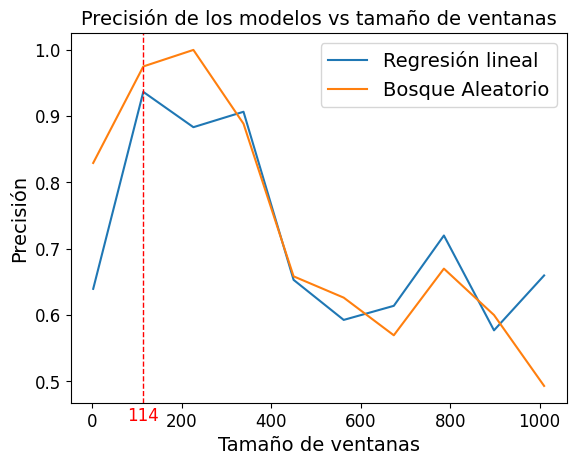

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, sharex=True, sharey=True)
axs.plot(windows, precisionX_lr_W, label='Regresión lineal')
axs.plot(windows, precisionX_rf_W, label='Bosque Aleatorio')

# Añadir la línea vertical punteada en x = 114
axs.axvline(x=114, color='red', linestyle='--', linewidth=1)
# Añadir la etiqueta 114 por debajo del eje x
axs.text(114, axs.get_ylim()[0] - (axs.get_ylim()[1] - axs.get_ylim()[0]) * 0.05, '114', fontsize=12, color='red', ha='center')

# Aumentar el tamaño de los números en los ejes x e y
axs.tick_params(axis='x', labelsize=12)
axs.tick_params(axis='y', labelsize=12)

axs.set_xlabel('Tamaño de ventanas', fontsize=14)
axs.set_ylabel('Precisión', fontsize=14)
axs.set_title('Precisión de los modelos vs tamaño de ventanas', fontsize=14)

plt.legend(fontsize=14)
plt.show()

### Bosque Aleatorio

In [14]:
%matplotlib qt
precision_mov_1_rf = [array[1] for array in precisionX_rf]
precision_mov_2_rf = [array[2] for array in precisionX_rf]
precision_mov_3_rf = [array[3] for array in precisionX_rf]
precision_mov_4_rf = [array[4] for array in precisionX_rf]
precision_quieto_rf = [array[0] for array in precisionX_rf]
fig, axs = plt.subplots(1, sharex=True, sharey=True)
#axs.plot(windows, recallX_lr, label='Regresión lineal')
axs.plot(windows, precision_mov_1_rf, label='Movimiento 1')
axs.plot(windows, precision_mov_2_rf, label='Movimiento 2')
axs.plot(windows, precision_mov_3_rf, label='Movimiento 3')
axs.plot(windows, precision_mov_4_rf, label='Movimiento 4')
axs.plot(windows, precision_quieto_rf, label='Quieto')

axs.set(xlabel='Tamaño de ventanas', ylabel='Precisión')
axs.set_title('Bosque Aleatorio')

plt.legend()
plt.show()

### Regresión lineal

In [ ]:
%matplotlib qt
precision_mov_1_lr = [array[1] for array in precisionX_lr]
precision_mov_2_lr = [array[2] for array in precisionX_lr]
precision_mov_3_lr = [array[3] for array in precisionX_lr]
precision_mov_4_lr = [array[4] for array in precisionX_lr]
precision_quieto_lr = [array[0] for array in precisionX_lr]
fig, axs = plt.subplots(1, sharex=True, sharey=True)
#axs.plot(windows, recallX_lr, label='Regresión lineal')
axs.plot(windows, precision_mov_1_lr, label='Movimiento 1')
axs.plot(windows, precision_mov_2_lr, label='Movimiento 2')
axs.plot(windows, precision_mov_3_lr, label='Movimiento 3')
axs.plot(windows, precision_mov_4_lr, label='Movimiento 4')
axs.plot(windows, precision_quieto_lr, label='Quieto')

axs.set(xlabel='Tamaño de ventanas', ylabel='recall')
axs.set_title('Regresión lineal')

plt.legend()
plt.show()

In [32]:
%matplotlib qt
precision_mov_1_rf = [array[1] for array in precisionX_rf]
precision_mov_2_rf = [array[2] for array in precisionX_rf]
precision_mov_3_rf = [array[3] for array in precisionX_rf]
precision_mov_4_rf = [array[4] for array in precisionX_rf]
precision_quieto_rf = [array[0] for array in precisionX_rf]
precision_mov_1_lr = [array[1] for array in precisionX_lr]
precision_mov_2_lr = [array[2] for array in precisionX_lr]
precision_mov_3_lr = [array[3] for array in precisionX_lr]
precision_mov_4_lr = [array[4] for array in precisionX_lr]
precision_quieto_lr = [array[0] for array in precisionX_lr]

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, sharey=True)
#axs.plot(windows, recallX_lr, label='Regresión lineal')
ax1.plot(windows, precision_mov_1_rf, label='Movimiento 1', color='red')
ax1.plot(windows, precision_mov_2_rf, label='Movimiento 2', color='yellow')
ax1.plot(windows, precision_mov_3_rf, label='Movimiento 3', color='blue')
ax1.plot(windows, precision_mov_4_rf, label='Movimiento 4', color='cyan')
ax1.plot(windows, precision_quieto_rf, label='Quieto', color='green')

ax1.set_ylabel('Precisión', fontsize=14)
ax1.set_title('Bosque Aleatorio', fontsize=14)


#axs.plot(windows, recallX_lr, label='Regresión lineal')
ax2.plot(windows, precision_mov_1_lr, color='red')
ax2.plot(windows, precision_mov_2_lr, color='yellow')
ax2.plot(windows, precision_mov_3_lr, color='blue')
ax2.plot(windows, precision_mov_4_lr, color='cyan')
ax2.plot(windows, precision_quieto_lr, color='green')

ax2.set_xlabel('Tamaño de ventanas', fontsize=14)
ax2.set_ylabel('Precisión', fontsize=14)
ax2.set_title('Regresión lineal',fontsize=14)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
# Añadir la línea vertical punteada en x = 114
ax1.axvline(x=114, color='gray', linestyle='--', linewidth=1)
ax2.axvline(x=114, color='gray', linestyle='--', linewidth=1)
# Añadir la etiqueta 114 por debajo del eje x
ax2.text(114, ax2.get_ylim()[0] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.1, '114', fontsize=12, color='gray', ha='center')


ax1.legend()
plt.show()

## Recall

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, sharex=True, sharey=True)
axs.plot(windows, recallX_lr_W, label='Regresión lineal')
axs.plot(windows, recallX_rf_W, label='Bosque Aleatorio')

# Añadir la línea vertical punteada en x = 114
axs.axvline(x=114, color='red', linestyle='--', linewidth=1)
# Añadir la etiqueta 114 por debajo del eje x
axs.text(114, axs.get_ylim()[0] - (axs.get_ylim()[1] - axs.get_ylim()[0]) * 0.05, '114', fontsize=12, color='red', ha='center')

# Aumentar el tamaño de los números en los ejes x e y
axs.tick_params(axis='x', labelsize=12)
axs.tick_params(axis='y', labelsize=12)

axs.set_xlabel('Tamaño de ventanas', fontsize=14)
axs.set_ylabel('Recuperación', fontsize=14)
axs.set_title('Recuperación de los modelos vs tamaño de ventanas', fontsize=14)

plt.legend(fontsize=14)
plt.show()

### Bosque Aleatorio

In [ ]:
%matplotlib qt
recall_mov_1_rf = [array[0] for array in recallX_rf]
recall_mov_2_rf = [array[1] for array in recallX_rf]
recall_mov_3_rf = [array[2] for array in recallX_rf]
recall_mov_4_rf = [array[3] for array in recallX_rf]
recall_quieto_rf = [array[0] for array in recallX_rf]
fig, axs = plt.subplots(1, sharex=True, sharey=True)
#axs.plot(windows, recallX_lr, label='Regresión lineal')
axs.plot(windows, recall_mov_1_rf, label='Movimiento 1')
axs.plot(windows, recall_mov_2_rf, label='Movimiento 2')
axs.plot(windows, recall_mov_3_rf, label='Movimiento 3')
axs.plot(windows, recall_mov_4_rf, label='Movimiento 4')
axs.plot(windows, recall_quieto_rf, label='Quieto')

axs.set(xlabel='Tamaño de ventanas', ylabel='recall')
axs.set_title('Bosque Aleatorio')

plt.legend()
plt.show()

### Regresión lineal

In [ ]:
%matplotlib qt
recall_mov_1_lr = [array[1] for array in recallX_lr]
recall_mov_2_lr = [array[2] for array in recallX_lr]
recall_mov_3_lr = [array[3] for array in recallX_lr]
recall_mov_4_lr = [array[4] for array in recallX_lr]
recall_quieto_lr = [array[0] for array in recallX_lr]
fig, axs = plt.subplots(1, sharex=True, sharey=True)
#axs.plot(windows, recallX_lr, label='Regresión lineal')
axs.plot(windows, recall_mov_1_lr, label='Movimiento 1')
axs.plot(windows, recall_mov_2_lr, label='Movimiento 2')
axs.plot(windows, recall_mov_3_lr, label='Movimiento 3')
axs.plot(windows, recall_mov_4_lr, label='Movimiento 4')
axs.plot(windows, recall_quieto_lr, label='Quieto')

axs.set(xlabel='Tamaño de ventanas', ylabel='recall')
axs.set_title('Regresión lineal')

plt.legend()
plt.show()

In [33]:
%matplotlib qt
recall_mov_1_rf = [array[0] for array in recallX_rf]
recall_mov_2_rf = [array[1] for array in recallX_rf]
recall_mov_3_rf = [array[2] for array in recallX_rf]
recall_mov_4_rf = [array[3] for array in recallX_rf]
recall_quieto_rf = [array[0] for array in recallX_rf]
recall_mov_1_lr = [array[1] for array in recallX_lr]
recall_mov_2_lr = [array[2] for array in recallX_lr]
recall_mov_3_lr = [array[3] for array in recallX_lr]
recall_mov_4_lr = [array[4] for array in recallX_lr]
recall_quieto_lr = [array[0] for array in recallX_lr]

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, sharey=True)
#axs.plot(windows, recallX_lr, label='Regresión lineal')
ax1.plot(windows, recall_mov_1_rf, label='Movimiento 1', color='red')
ax1.plot(windows, recall_mov_2_rf, label='Movimiento 2', color='yellow')
ax1.plot(windows, recall_mov_3_rf, label='Movimiento 3', color='blue')
ax1.plot(windows, recall_mov_4_rf, label='Movimiento 4', color='cyan')
ax1.plot(windows, recall_quieto_rf, label='Quieto', color='green')

ax1.set_ylabel('Recuperación', fontsize=14)
ax1.set_title('Bosque Aleatorio', fontsize=14)


#axs.plot(windows, recallX_lr, label='Regresión lineal')
ax2.plot(windows, recall_mov_1_lr, color='red')
ax2.plot(windows, recall_mov_2_lr, color='yellow')
ax2.plot(windows, recall_mov_3_lr, color='blue')
ax2.plot(windows, recall_mov_4_lr, color='cyan')
ax2.plot(windows, recall_quieto_lr, color='green')

ax2.set_xlabel('Tamaño de ventanas', fontsize=14)
ax2.set_ylabel('Recuperación', fontsize=14)
ax2.set_title('Regresión lineal',fontsize=14)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
# Añadir la línea vertical punteada en x = 114
ax1.axvline(x=114, color='gray', linestyle='--', linewidth=1)
ax2.axvline(x=114, color='gray', linestyle='--', linewidth=1)
# Añadir la etiqueta 114 por debajo del eje x
ax2.text(114, ax2.get_ylim()[0] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.1, '114', fontsize=12, color='gray', ha='center')


ax1.legend()
plt.show()

## f1_score

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, sharex=True, sharey=True)
axs.plot(windows, fscoreX_lr_W, label='Regresión lineal')
axs.plot(windows, fscoreX_rf_W, label='Bosque Aleatorio')

# Añadir la línea vertical punteada en x = 114
axs.axvline(x=114, color='red', linestyle='--', linewidth=1)
# Añadir la etiqueta 114 por debajo del eje x
axs.text(114, axs.get_ylim()[0] - (axs.get_ylim()[1] - axs.get_ylim()[0]) * 0.05, '114', fontsize=12, color='red', ha='center')

# Aumentar el tamaño de los números en los ejes x e y
axs.tick_params(axis='x', labelsize=12)
axs.tick_params(axis='y', labelsize=12)

axs.set_xlabel('Tamaño de ventanas', fontsize=14)
axs.set_ylabel('f$_1$-score', fontsize=14)
axs.set_title('f$_1$-score de los modelos vs tamaño de ventanas', fontsize=14)

plt.legend(fontsize=14)
plt.show()

### Bosque Aleatorio

In [ ]:
%matplotlib qt
fscore_mov_1_rf = [array[1] for array in fscoreX_rf]
fscore_mov_2_rf = [array[2] for array in fscoreX_rf]
fscore_mov_3_rf = [array[3] for array in fscoreX_rf]
fscore_mov_4_rf = [array[4] for array in fscoreX_rf]
fscore_quieto_rf = [array[0] for array in fscoreX_rf]
fig, axs = plt.subplots(1, sharex=True, sharey=True)
#axs.plot(windows, recallX_lr, label='Regresión lineal')
axs.plot(windows, fscore_mov_1_rf, label='Movimiento 1')
axs.plot(windows, fscore_mov_2_rf, label='Movimiento 2')
axs.plot(windows, fscore_mov_3_rf, label='Movimiento 3')
axs.plot(windows, fscore_mov_4_rf, label='Movimiento 4')
axs.plot(windows, fscore_quieto_rf, label='Quieto')

axs.set(xlabel='Tamaño de ventanas', ylabel='f1_score')
axs.set_title('Regresión lineal')

plt.legend()
plt.show()

### Regresión lineal

In [31]:
%matplotlib qt
fscore_mov_1_lr = [array[1] for array in fscoreX_lr]
fscore_mov_2_lr = [array[2] for array in fscoreX_lr]
fscore_mov_3_lr = [array[3] for array in fscoreX_lr]
fscore_mov_4_lr = [array[4] for array in fscoreX_lr]
fscore_quieto_lr = [array[0] for array in fscoreX_lr]
fig, axs = plt.subplots(1, sharex=True, sharey=True)
#axs.plot(windows, recallX_lr, label='Regresión lineal')
axs.plot(windows, fscore_mov_1_lr, label='Movimiento 1')
axs.plot(windows, fscore_mov_2_lr, label='Movimiento 2')
axs.plot(windows, fscore_mov_3_lr, label='Movimiento 3')
axs.plot(windows, fscore_mov_4_lr, label='Movimiento 4')
axs.plot(windows, fscore_quieto_lr, label='Quieto')

axs.set(xlabel='Tamaño de ventanas', ylabel='f1_score')
axs.set_title('Bosque Aleatorio')

plt.legend(loc=(0.2, 0.05))
plt.show()

In [34]:
%matplotlib qt
fscore_mov_1_rf = [array[1] for array in fscoreX_rf]
fscore_mov_2_rf = [array[2] for array in fscoreX_rf]
fscore_mov_3_rf = [array[3] for array in fscoreX_rf]
fscore_mov_4_rf = [array[4] for array in fscoreX_rf]
fscore_quieto_rf = [array[0] for array in fscoreX_rf]
fscore_mov_1_lr = [array[1] for array in fscoreX_lr]
fscore_mov_2_lr = [array[2] for array in fscoreX_lr]
fscore_mov_3_lr = [array[3] for array in fscoreX_lr]
fscore_mov_4_lr = [array[4] for array in fscoreX_lr]
fscore_quieto_lr = [array[0] for array in fscoreX_lr]

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, sharey=True)
#axs.plot(windows, recallX_lr, label='Regresión lineal')
ax1.plot(windows, fscore_mov_1_rf, label='Movimiento 1', color='red')
ax1.plot(windows, fscore_mov_2_rf, label='Movimiento 2', color='yellow')
ax1.plot(windows, fscore_mov_3_rf, label='Movimiento 3', color='blue')
ax1.plot(windows, fscore_mov_4_rf, label='Movimiento 4', color='cyan')
ax1.plot(windows, fscore_quieto_rf, label='Quieto', color='green')

ax1.set_ylabel('f$_1$-score', fontsize=14)
ax1.set_title('Bosque Aleatorio', fontsize=14)


#axs.plot(windows, recallX_lr, label='Regresión lineal')
ax2.plot(windows, fscore_mov_1_lr, color='red')
ax2.plot(windows, fscore_mov_2_lr, color='yellow')
ax2.plot(windows, fscore_mov_3_lr, color='blue')
ax2.plot(windows, fscore_mov_4_lr, color='cyan')
ax2.plot(windows, fscore_quieto_lr, color='green')

ax2.set_xlabel('Tamaño de ventanas', fontsize=14)
ax2.set_ylabel('f$_1$-score', fontsize=14)
ax2.set_title('Regresión lineal',fontsize=14)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
# Añadir la línea vertical punteada en x = 114
ax1.axvline(x=114, color='gray', linestyle='--', linewidth=1)
ax2.axvline(x=114, color='gray', linestyle='--', linewidth=1)
# Añadir la etiqueta 114 por debajo del eje x
ax2.text(114, ax2.get_ylim()[0] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.1, '114', fontsize=12, color='gray', ha='center')


ax1.legend()
plt.show()

### Accuracy vs tamaño ventanas

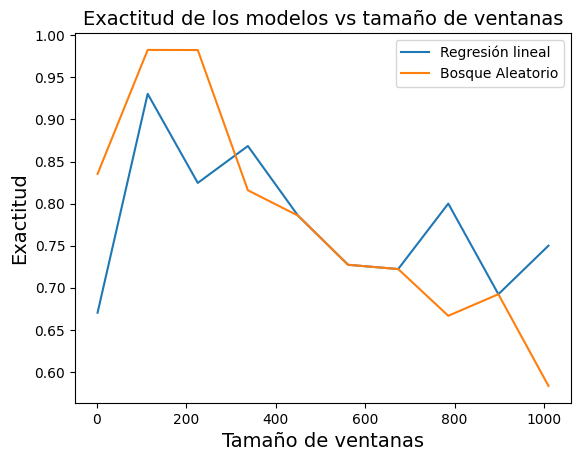

In [29]:
fig, axs = plt.subplots(1, sharex=True, sharey=True)
axs.plot(windows, accuracyX_lr, label='Regresión lineal')
axs.plot(windows, accuracyX_rf, label='Bosque Aleatorio')

axs.set_xlabel('Tamaño de ventanas', fontsize=14)
axs.set_ylabel('Exactitud', fontsize=14)
axs.set_title('Exactitud de los modelos vs tamaño de ventanas', fontsize=14)

plt.legend()
plt.show()

In [35]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, sharex=True, sharey=True)
axs.plot(windows, accuracyX_lr, label='Regresión lineal')
axs.plot(windows, accuracyX_rf, label='Bosque Aleatorio')

# Añadir la línea vertical punteada en x = 114
axs.axvline(x=114, color='gray', linestyle='--', linewidth=1)
# Añadir la etiqueta 114 por debajo del eje x
axs.text(114, axs.get_ylim()[0] - (axs.get_ylim()[1] - axs.get_ylim()[0]) * 0.05, '114', fontsize=12, color='gray', ha='center')

# Aumentar el tamaño de los números en los ejes x e y
axs.tick_params(axis='x', labelsize=12)
axs.tick_params(axis='y', labelsize=12)

axs.set_xlabel('Tamaño de ventanas', fontsize=14)
axs.set_ylabel('Exactitud', fontsize=14)
axs.set_title('Exactitud de los modelos vs tamaño de ventanas', fontsize=14)

plt.legend(fontsize=14)
plt.show()